# Step 2: Advanced LSTM Model with Patient-Based Cross-Validation

## 1. Overview
Time series classification of glycemic state using an LSTM with attention. Evaluation is strictly patient-independent via leave-one-patient-out to approximate deployment on unseen individuals.

## 2. Methodology

### 2.1 Data Preparation
- Load precomputed physiological feature set (volunteer1 dataset)
- Select channel group (e.g. Hand1, Hand2)
- Chronologically sort per patient
- Derive future glycemic state targets at specified prediction horizons
- Encode classes and scale features using training-only data

### 2.2 Cross-Validation (Leave-One-Patient-Out)
For each patient p:
- Test set: all samples of p
- Remaining patients: split into training + validation (single held-out patient for validation when available)
- Aggregate metrics: mean and standard deviation across folds

### 2.3 Metrics
Accuracy, macro F1, macro precision, macro recall, validation–test gap (generalization indicator)

## 3. Workflow

```
Load Features
   ↓
Per Horizon Loop
   ↓
Construct Future Targets
   ↓
Patient-Based Split (LOO)
   ↓
Train (class weights, regularization)
   ↓
Early Stopping (validation loss)
   ↓
Evaluate (val + test)
   ↓
Aggregate Across Folds
   ↓
Summarize Across Horizons
```

## 4. Model Architecture

```
Input
  Shape: [batch, seq_len (60), features]

LSTM
  Hidden size: 64
  Layers: 2
  Bidirectional: False (enforcing causal modeling)
  Dropout (inter-layer): 0.5
  Output: [batch, seq_len, 64]

Attention
  Score: Linear(64 → 1)
  Weights: softmax over seq_len
  Context: weighted sum → [batch, 64]

(Optional) BatchNorm on context

Dropout
  Rate: 0.5

Fully Connected
  Linear(64 → 3)

Output
  Logits per class (Hyperglycemia, Normoglycemia, Hypoglycemia)
```

## 5. Regularization & Generalization Controls
- Reduced hidden size relative to larger baselines
- Dropout at LSTM and projection stages
- Optional batch normalization
- Weight decay (L2)
- Early stopping
- Class weighting for imbalance
- Patient-disjoint evaluation (prevents leakage)

## 6. Execution Flow per Horizon
1. Prepare horizon-specific targets
2. Enumerate patients as test folds
3. Scale features using training subset only
4. Generate fixed-length sequences per patient
5. Train with early stopping
6. Reload best checkpoint
7. Compute validation–test gap
8. Store fold result
9. Aggregate and plot across horizons

## 7. Key Points of this special case
- True out-of-patient generalization (we hope to acieve this, since it is the same patient, devided by time-series)
- Attention highlights salient temporal regions
- Explicit overfitting monitoring via gap
- Horizon-wise performance profiling
- Patient-based cross-validation for realistic deployment simulation

#### Imports and Setup:

In [1]:
# General imports:

# Disable warnings:
import warnings
warnings.filterwarnings('ignore')

# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import gc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Utils
from utils import utils

# Set PyTorch device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"✓ GPU available: {torch.cuda.get_device_name()}")
    print(f"✓ CUDA version: {torch.version.cuda}")
else:
    print("ℹ Running on CPU")

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Plotting enhancements
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8-whitegrid')


ℹ Running on CPU


In [2]:
# Key Settings:

# Subjects and their types
Subject = "volunteer"  # Special case for volunteer data processing

# Path and directories
base_dir = Path("../../../Data")

# Output directory for saving results
output_dir = base_dir / "ProcessedData"
os.makedirs(output_dir, exist_ok=True)

features = "combined_features_and_targets_volunteer1.csv"

# Channel grouping (special case for volunteer data)
signal_channels = {
    'Hand': ['Hand1', 'Hand2'],
}

# Channel to be used for classification
channel = "Hand1"  # Specify the channel to be used, e.g., 'Hand1' or  'Hand2'

# Tunable hyperparameters
prediction_horizons_to_test = [0, 10, 20, 30, 40, 60]  # Prediction horizons in minutes to test
sequence_length = 30  # Sequence length for LSTM input (time steps)
learning_rate = 0.00005  # Learning rate for Adam optimizer
batch_size = 32  # Batch size for training
num_epochs = 100  # Training epochs
patience = 15  # Early stopping patience to prevent overfitting
hidden_size = 32  # LSTM
num_layers = 2  # LSTM layers
dropout_rate = 0.6  # Regularized dropout rate

# Additional regularization parameters
weight_decay = 0.01  # L2 regularization
use_batch_norm = True  # Add batch normalization


#### Load and Prepare Data:

In [3]:
# Load the feature set for Volunteer1
feature_set_path = output_dir / features
if not feature_set_path.exists():
    raise FileNotFoundError(f"Feature set file not found: {feature_set_path}")

print(f"Feature set file: {feature_set_path}")
print("Data will be loaded and processed for each prediction horizon separately")


Feature set file: ..\..\..\Data\ProcessedData\combined_features_and_targets_volunteer1.csv
Data will be loaded and processed for each prediction horizon separately


#### Define helper functions for sequence creation and patient splitting

In [4]:
def create_sequences(X, y, patients, sequence_length):
    """
    Create sequences for LSTM training.

    Args:
        X: Feature matrix (num_samples, num_features)
        y: Target vector (num_samples,)
        patients: Patient IDs (num_samples,)
        sequence_length: Length of each sequence

    Returns:
        X_sequences: (num_sequences, seq_len, num_features)
        y_sequences: (num_sequences,)
        patient_sequences: (num_sequences,)
    """
    X_sequences = []
    y_sequences = []
    patient_sequences = []

    # Create sequences for each patient separately
    for patient_id in np.unique(patients):
        patient_mask = patients == patient_id
        patient_X = X[patient_mask]
        patient_y = y[patient_mask]

        # Create sequences for this patient
        for i in range(len(patient_X) - sequence_length + 1):
            X_sequences.append(patient_X[i:i+sequence_length])
            y_sequences.append(patient_y[i+sequence_length-1])  # Use the last target in the sequence
            patient_sequences.append(patient_id)

    return np.array(X_sequences), np.array(y_sequences), np.array(patient_sequences)

def split_patients(patients, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split patients into train, validation, and test sets.
    """
    unique_patients = np.unique(patients)
    n_patients = len(unique_patients)

    # Shuffle patients
    np.random.seed(42)
    shuffled_patients = np.random.permutation(unique_patients)

    # Calculate split indices
    train_end = int(n_patients * train_ratio)
    val_end = int(n_patients * (train_ratio + val_ratio))

    train_patients = shuffled_patients[:train_end]
    val_patients = shuffled_patients[train_end:val_end]
    test_patients = shuffled_patients[val_end:]

    return train_patients, val_patients, test_patients


#### Define PyTorch Dataset and LSTM Model classes

In [5]:
class GlycemicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=3, dropout=0.2, use_batch_norm=False):
        super(AttentionLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_batch_norm = use_batch_norm

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Batch normalization for LSTM output
        if self.use_batch_norm:
            self.batch_norm = nn.BatchNorm1d(hidden_size)

        # Attention mechanism
        self.attention = nn.Linear(hidden_size, 1)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Output layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_size)

        # Apply attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch, seq_len, 1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # (batch, hidden_size)

        # Apply batch normalization if enabled
        if self.use_batch_norm and context_vector.size(0) > 1:  # Skip BN for single samples
            context_vector = self.batch_norm(context_vector)

        # Apply dropout
        context_vector = self.dropout(context_vector)

        # Final classification layer
        output = self.fc(context_vector)

        return output


#### Define training functions with comprehensive metrics

In [6]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch_y.size(0)
        correct += predicted.eq(batch_y).sum().item()

    return total_loss / len(train_loader), correct / total

def validate_with_metrics(model, val_loader, criterion, device):
    """Validation with comprehensive metrics"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    # Calculate comprehensive metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    macro_f1 = f1_score(all_targets, all_predictions, average='macro')
    macro_precision = precision_score(all_targets, all_predictions, average='macro')
    macro_recall = recall_score(all_targets, all_predictions, average='macro')

    return total_loss / len(val_loader), accuracy, macro_f1, macro_precision, macro_recall

def validate(model, val_loader, criterion, device):
    """Simple validation for compatibility"""
    loss, acc, _, _, _ = validate_with_metrics(model, val_loader, criterion, device)
    return loss, acc


#### Iterate over prediction horizons and train/test models


ITERATING OVER ALL PREDICTION HORIZONS

==================== TRAINING FOR HORIZON: 0 MINUTES ====================

PREPARING DATA FOR PREDICTION HORIZON: 0 MINUTES
Data loaded with shape: (2537, 68)
Data shape after removing NaN targets: (2537, 32)
Feature matrix shape: (2537, 26)
Number of unique patients: 4
Target classes: ['Hyperglycemia' 'Hypoglycemia' 'Normal']
Total unique patients: 4
✓ Using patient-based cross-validation for proper generalization assessment

--- Cross-validation fold: Test Patient = volunteer_part1 ---
Training set: 1357 samples from patients ['volunteer_part2' 'volunteer_part3']
Validation set: 636 samples
Test set: 544 samples from patient volunteer_part1
Encoded classes: {'Hyperglycemia': 0, 'Hypoglycemia': 1, 'Normal': 2}
Training data class distribution for patient volunteer_part1 fold:
  Hyperglycemia: 395 samples (29.1%)
  Hypoglycemia: 314 samples (23.1%)
  Normal: 648 samples (47.8%)
Sequences - Train: (1299, 30, 26), Val: (607, 30, 26), Test: (515, 3

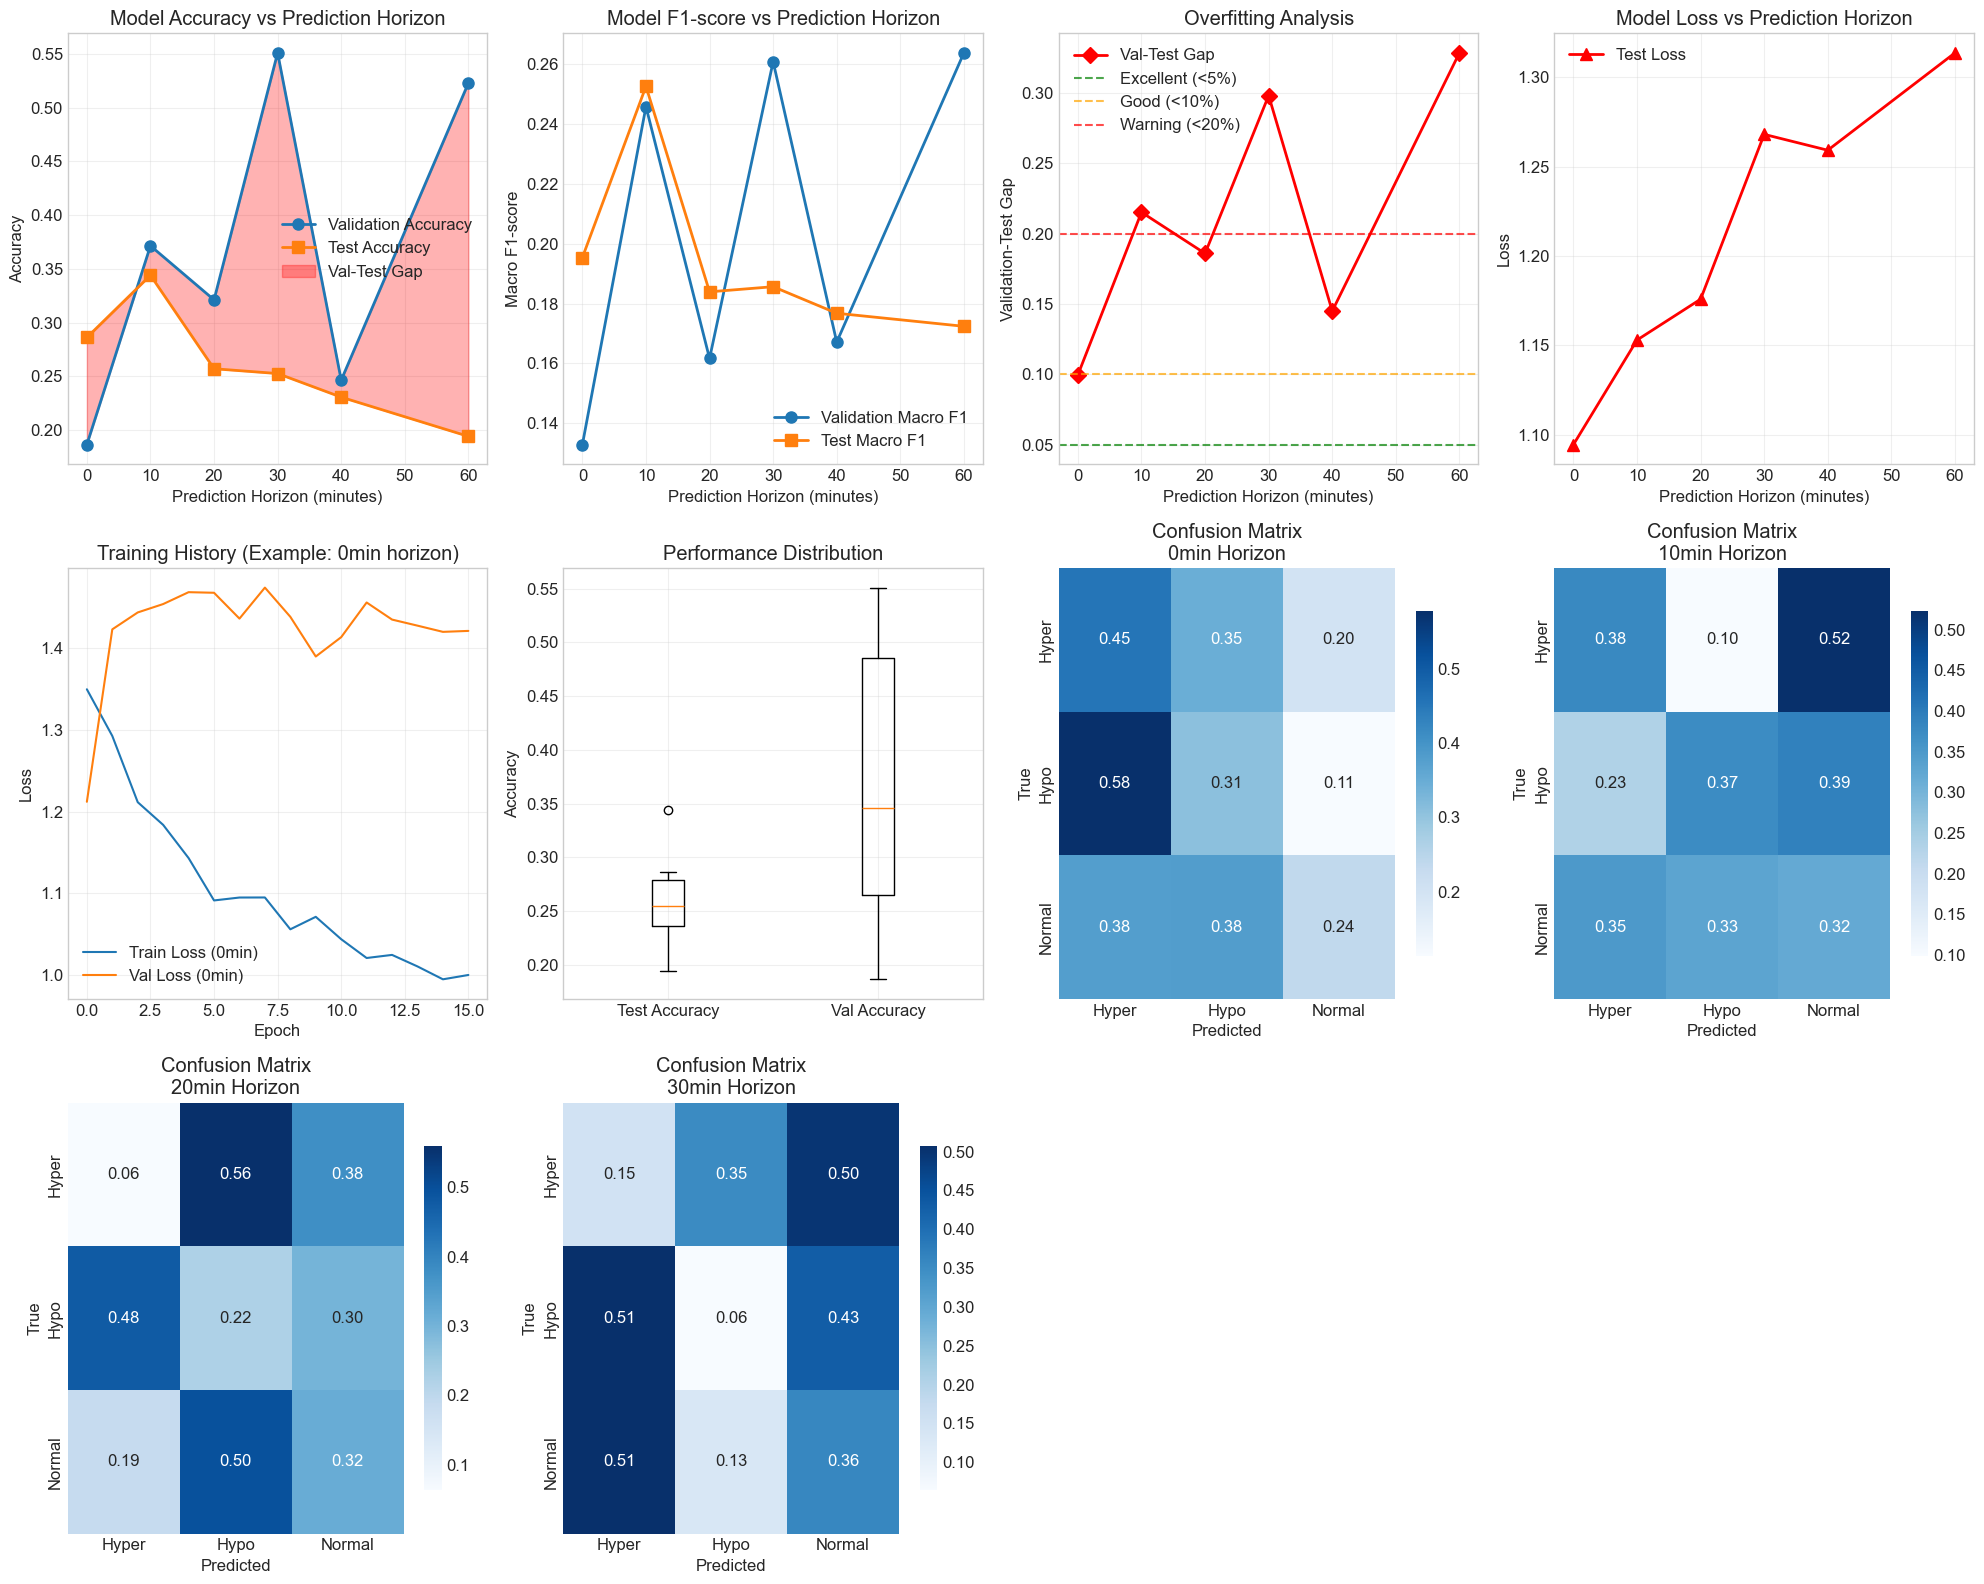


DETAILED CONFUSION MATRIX ANALYSIS

--- Horizon: 0 minutes ---
Confusion Matrix (Raw Counts):
                 Predicted
               Hyper  Hypo  Normal
True Hyperg   203   155     90
True Hypogl   329   176     65
True Normal   533   535    335

Per-class Performance:
  Hyperglycemia: Precision=0.191, Recall=0.453, F1=0.268
  Hypoglycemia: Precision=0.203, Recall=0.309, F1=0.245
  Normal: Precision=0.684, Recall=0.239, F1=0.354

--- Horizon: 10 minutes ---
Confusion Matrix (Raw Counts):
                 Predicted
               Hyper  Hypo  Normal
True Hyperg   172    45    238
True Hypogl   133   212    222
True Normal   476   449    435

Per-class Performance:
  Hyperglycemia: Precision=0.220, Recall=0.378, F1=0.278
  Hypoglycemia: Precision=0.300, Recall=0.374, F1=0.333
  Normal: Precision=0.486, Recall=0.320, F1=0.386

--- Horizon: 20 minutes ---
Confusion Matrix (Raw Counts):
                 Predicted
               Hyper  Hypo  Normal
True Hyperg    29   258    174
True Hyp

In [7]:
def prepare_data_for_horizon(horizon_minutes):
    """Prepare data for a specific prediction horizon, constructing target from end_time"""
    print(f"\n{'='*60}")
    print(f"PREPARING DATA FOR PREDICTION HORIZON: {horizon_minutes} MINUTES")
    print(f"{'='*60}")

    # Load fresh data for this horizon
    temp_data = pd.read_csv(feature_set_path)
    print(f"Data loaded with shape: {temp_data.shape}")

    # Keep only required columns
    columns_to_keep = [col for col in temp_data.columns if col.startswith(channel) or col in ['start_time', 'end_time', 'CGM', 'patient']]
    temp_data = temp_data[columns_to_keep]

    # Convert time columns to datetime for proper time-based target construction
    temp_data['end_time'] = pd.to_datetime(temp_data['end_time'])
    temp_data = temp_data.sort_values(['patient', 'end_time']).reset_index(drop=True)

    # Apply classification target to CGM values
    temp_data['glycemic_state'] = temp_data['CGM'].apply(utils.classify_glycemic_state)

    # Create target variable based on end_time + horizon_minutes
    # For each row, find the glycemic state at end_time + horizon_minutes
    temp_data[f'target_glycemic_state_in_{horizon_minutes}min'] = None

    for patient_id in temp_data['patient'].unique():
        patient_mask = temp_data['patient'] == patient_id
        patient_data = temp_data[patient_mask].copy()

        for idx in patient_data.index:
            current_end_time = temp_data.loc[idx, 'end_time']
            target_time = current_end_time + pd.Timedelta(minutes=horizon_minutes)

            # Find the closest measurement at or after target_time for this patient
            future_measurements = patient_data[patient_data['end_time'] >= target_time]
            if not future_measurements.empty:
                closest_idx = future_measurements.iloc[0].name
                target_state = temp_data.loc[closest_idx, 'glycemic_state']
                temp_data.loc[idx, f'target_glycemic_state_in_{horizon_minutes}min'] = target_state

    # Clean and prepare data
    temp_data_clean = temp_data.dropna(subset=[f'target_glycemic_state_in_{horizon_minutes}min']).copy()
    print(f"Data shape after removing NaN targets: {temp_data_clean.shape}")

    if len(temp_data_clean) < sequence_length:
        print(f"❌ Not enough data for horizon {horizon_minutes} minutes")
        return None

    # Separate features and targets
    feature_columns = [col for col in temp_data_clean.columns if col not in ['start_time', 'end_time', f'target_glycemic_state_in_{horizon_minutes}min', 'patient', 'CGM', 'glycemic_state']]
    X = temp_data_clean[feature_columns].values
    y = temp_data_clean[f'target_glycemic_state_in_{horizon_minutes}min'].values
    patients = temp_data_clean['patient'].values

    print(f"Feature matrix shape: {X.shape}")
    print(f"Number of unique patients: {len(np.unique(patients))}")
    print(f"Target classes: {np.unique(y)}")

    return X, y, patients, feature_columns

def train_and_evaluate_horizon(horizon_minutes):
    """Train and evaluate model for a specific prediction horizon using patient-based cross-validation"""
    print(f"\n{'='*20} TRAINING FOR HORIZON: {horizon_minutes} MINUTES {'='*20}")

    # Prepare data for this horizon
    data_result = prepare_data_for_horizon(horizon_minutes)
    if data_result is None:
        return None

    X, y, patients, feature_columns = data_result

    # Get unique patients
    unique_patients = np.unique(patients)
    print(f"Total unique patients: {len(unique_patients)}")
    
    # PATIENT-BASED CROSS-VALIDATION APPROACH
    if len(unique_patients) >= 3:
        print("✓ Using patient-based cross-validation for proper generalization assessment")

        # For 4 patients, we'll use Leave-One-Out Cross-Validation (LOOCV)
        # Each patient will serve as test set once, others split into train/val
        cv_results = []

        for test_patient in unique_patients:
            print(f"\n--- Cross-validation fold: Test Patient = {test_patient} ---")

            # Split data by patients
            test_mask = patients == test_patient
            train_val_mask = ~test_mask

            X_train_val = X[train_val_mask]
            y_train_val = y[train_val_mask]
            patients_train_val = patients[train_val_mask]

            X_test = X[test_mask]
            y_test = y[test_mask]

            # Further split train_val into train and validation
            # Use one patient for validation, rest for training
            remaining_patients = unique_patients[unique_patients != test_patient]

            if len(remaining_patients) >= 2:
                # Use last patient as validation, others as training
                val_patient = remaining_patients[-1]
                train_patients = remaining_patients[:-1]

                val_mask_in_trainval = patients_train_val == val_patient
                train_mask_in_trainval = ~val_mask_in_trainval

                X_train = X_train_val[train_mask_in_trainval]
                y_train = y_train_val[train_mask_in_trainval]
                patients_train = patients_train_val[train_mask_in_trainval]

                X_val = X_train_val[val_mask_in_trainval]
                y_val = y_train_val[val_mask_in_trainval]
            else:
                # If only 2 remaining patients, use part of training data for validation
                n_train_val = len(X_train_val)
                train_end = int(0.8 * n_train_val)

                X_train = X_train_val[:train_end]
                y_train = y_train_val[:train_end]
                patients_train = patients_train_val[:train_end]

                X_val = X_train_val[train_end:]
                y_val = y_train_val[train_end:]

            print(f"Training set: {len(X_train)} samples from patients {np.unique(patients_train)}")
            print(f"Validation set: {len(X_val)} samples")
            print(f"Test set: {len(X_test)} samples from patient {test_patient}")

            # Check if we have enough data for sequences
            if len(X_train) < sequence_length or len(X_val) < sequence_length or len(X_test) < sequence_length:
                print(f"⚠️  Insufficient data for patient {test_patient} fold, skipping...")
                continue

            # Train model for this fold
            fold_result = train_single_fold(
                X_train, y_train, patients_train,
                X_val, y_val,
                X_test, y_test,
                horizon_minutes, test_patient
            )

            if fold_result is not None:
                cv_results.append(fold_result)

        # Aggregate cross-validation results
        if cv_results:
            print(f"\n{'='*60}")
            print(f"CROSS-VALIDATION SUMMARY FOR {horizon_minutes}min HORIZON")
            print(f"{'='*60}")

            # Calculate mean and std of metrics across folds
            val_accs = [r['val_accuracy'] for r in cv_results]
            test_accs = [r['test_accuracy'] for r in cv_results]
            val_f1s = [r['val_macro_f1'] for r in cv_results]
            test_f1s = [r['test_macro_f1'] for r in cv_results]
            gaps = [r['val_test_gap'] for r in cv_results]

            mean_val_acc = np.mean(val_accs)
            mean_test_acc = np.mean(test_accs)
            mean_gap = np.mean(gaps)
            std_test_acc = np.std(test_accs)

            print(f"Cross-validation results ({len(cv_results)} folds):")
            print(f"  Mean Test Accuracy: {mean_test_acc:.4f} ± {std_test_acc:.4f}")
            print(f"  Mean Validation Accuracy: {mean_val_acc:.4f}")
            print(f"  Mean Val-Test Gap: {mean_gap:.4f}")
            print(f"  Test F1 scores: {[f'{f:.3f}' for f in test_f1s]}")

            # Return aggregated results
            return {
                'horizon': horizon_minutes,
                'val_accuracy': mean_val_acc,
                'val_macro_f1': np.mean(val_f1s),
                'val_macro_precision': np.mean([r['val_macro_precision'] for r in cv_results]),
                'val_macro_recall': np.mean([r['val_macro_recall'] for r in cv_results]),
                'val_loss': np.mean([r['val_loss'] for r in cv_results]),
                'test_accuracy': mean_test_acc,
                'test_accuracy_std': std_test_acc,
                'test_macro_f1': np.mean(test_f1s),
                'test_macro_precision': np.mean([r['test_macro_precision'] for r in cv_results]),
                'test_macro_recall': np.mean([r['test_macro_recall'] for r in cv_results]),
                'test_loss': np.mean([r['test_loss'] for r in cv_results]),
                'n_sequences': int(np.mean([r['n_sequences'] for r in cv_results])),
                'val_test_gap': mean_gap,
                'cv_folds': len(cv_results),
                'individual_results': cv_results,
                'train_history': cv_results[0]['train_history'] if cv_results else None  # Use first fold's history
            }
        else:
            print(f"❌ No successful cross-validation folds for horizon {horizon_minutes} minutes")
            return None

    else:
        print(f"❌ Insufficient patients ({len(unique_patients)}) for cross-validation")
        return None

def train_single_fold(X_train, y_train, patients_train, X_val, y_val, X_test, y_test, horizon_minutes, test_patient):
    """Train model for a single cross-validation fold"""

    # Encode target labels using ONLY training data
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Check if all classes are present in training data
    if len(np.unique(y_train_encoded)) < 3:
        print(f"Warning: Only {len(np.unique(y_train_encoded))} classes in training data for patient {test_patient}")
        # Still proceed but note this limitation

    try:
        y_val_encoded = label_encoder.transform(y_val)
        y_test_encoded = label_encoder.transform(y_test)
    except ValueError as e:
        print(f"Error encoding labels for patient {test_patient}: {e}")
        print(f"Training classes: {label_encoder.classes_}")
        print(f"Validation classes: {np.unique(y_val)}")
        print(f"Test classes: {np.unique(y_test)}")
        return None

    num_classes = len(label_encoder.classes_)
    print(f"Encoded classes: {dict(zip(label_encoder.classes_, range(num_classes)))}")

    # Normalize features using ONLY training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Calculate class weights using ONLY training data
    if len(np.unique(y_train_encoded)) > 1:
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
        # Pad with 1.0 for missing classes
        full_class_weights = np.ones(num_classes)
        for i, cls in enumerate(np.unique(y_train_encoded)):
            full_class_weights[cls] = class_weights[i]
        class_weights_tensor = torch.FloatTensor(full_class_weights).to(device)
    else:
        class_weights_tensor = torch.ones(num_classes).to(device)

    # Print class distribution for training data only
    unique_classes, class_counts = np.unique(y_train_encoded, return_counts=True)
    print(f"Training data class distribution for patient {test_patient} fold:")
    for i, (cls_idx, count) in enumerate(zip(unique_classes, class_counts)):
        cls_name = label_encoder.classes_[cls_idx]
        print(f"  {cls_name}: {count} samples ({count/len(y_train_encoded)*100:.1f}%)")

    # Create sequences for each set separately
    X_train_sequences, y_train_sequences, _ = create_sequences(X_train_scaled, y_train_encoded, patients_train, sequence_length)
    X_val_sequences, y_val_sequences, _ = create_sequences(X_val_scaled, y_val_encoded,
                                                          np.full(len(X_val), f"val_{test_patient}"), sequence_length)
    X_test_sequences, y_test_sequences, _ = create_sequences(X_test_scaled, y_test_encoded,
                                                           np.full(len(X_test), test_patient), sequence_length)

    print(f"Sequences - Train: {X_train_sequences.shape}, Val: {X_val_sequences.shape}, Test: {X_test_sequences.shape}")

    # Check if we have enough sequences
    if len(X_train_sequences) == 0 or len(X_val_sequences) == 0 or len(X_test_sequences) == 0:
        print(f"Insufficient sequences for patient {test_patient} fold")
        return None

    # Create datasets and data loaders
    train_dataset = GlycemicDataset(X_train_sequences, y_train_sequences)
    val_dataset = GlycemicDataset(X_val_sequences, y_val_sequences)
    test_dataset = GlycemicDataset(X_test_sequences, y_test_sequences)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    num_features = X_train_sequences.shape[2]
    model = AttentionLSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers,
                         num_classes=num_classes, dropout=dropout_rate, use_batch_norm=use_batch_norm)
    model = model.to(device)

    # Define loss function and optimizer with weight decay
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training parameters
    best_val_loss = float('inf')
    patience_counter = 0

    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    print(f"Training model for test patient {test_patient}...")

    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_macro_f1, val_macro_precision, val_macro_recall = validate_with_metrics(model, val_loader, criterion, device)

        # Save history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), f'best_lstm_model_{horizon_minutes}min_patient_{test_patient}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1} for patient {test_patient}')
                break

    # Load best model and evaluate
    model.load_state_dict(torch.load(f'best_lstm_model_{horizon_minutes}min_patient_{test_patient}.pth'))

    # Comprehensive evaluation with prediction collection for confusion matrix
    val_loss, val_acc, val_macro_f1, val_macro_precision, val_macro_recall = validate_with_metrics(model, val_loader, criterion, device)
    test_loss, test_acc, test_macro_f1, test_macro_precision, test_macro_recall = validate_with_metrics(model, test_loader, criterion, device)

    # Collect test predictions for confusion matrix
    model.eval()
    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = outputs.max(1)
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(batch_y.cpu().numpy())

    print(f"Patient {test_patient} Results - Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}, Gap: {abs(val_acc-test_acc):.4f}")

    return {
        'test_patient': test_patient,
        'val_accuracy': val_acc,
        'val_macro_f1': val_macro_f1,
        'val_macro_precision': val_macro_precision,
        'val_macro_recall': val_macro_recall,
        'val_loss': val_loss,
        'test_accuracy': test_acc,
        'test_macro_f1': test_macro_f1,
        'test_macro_precision': test_macro_precision,
        'test_macro_recall': test_macro_recall,
        'test_loss': test_loss,
        'n_sequences': len(X_test_sequences),
        'val_test_gap': abs(val_acc - test_acc),
        'test_predictions': test_predictions,  # NEW: For confusion matrix
        'test_true_labels': test_true_labels,  # NEW: For confusion matrix
        'train_history': {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }
    }
# Run training and evaluation for all prediction horizons
print("\n" + "="*80)
print("ITERATING OVER ALL PREDICTION HORIZONS")
print("="*80)

all_results = []
for horizon in prediction_horizons_to_test:
    result = train_and_evaluate_horizon(horizon)
    if result is not None:
        all_results.append(result)

    # Clean up memory after each horizon
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# Summary table of all horizons
if all_results:
    print(f"\n{'='*80}")
    print("SUMMARY: ALL PREDICTION HORIZONS RESULTS")
    print(f"{'='*80}")
    print(f"{'Horizon':<8} {'Val Acc':<8} {'Test Acc':<9} {'Gap':<6} {'Val F1':<8} {'Test F1':<8} {'N_Seq':<6} {'CV Folds':<8}")
    print("-" * 80)
    for result in all_results:
        gap = result.get('val_test_gap', abs(result['val_accuracy'] - result['test_accuracy']))
        cv_folds = result.get('cv_folds', 'N/A')
        print(f"{result['horizon']:<8} {result['val_accuracy']:<8.4f} {result['test_accuracy']:<9.4f} "
              f"{gap:<6.3f} {result['val_macro_f1']:<8.4f} {result['test_macro_f1']:<8.4f} "
              f"{result['n_sequences']:<6} {cv_folds:<8}")

    # Calculate average gap
    avg_gap = np.mean([result.get('val_test_gap', abs(result['val_accuracy'] - result['test_accuracy'])) for result in all_results])
    print(f"\nAverage Validation-Test Gap: {avg_gap:.3f}")
    if avg_gap < 0.05:
        print("EXCELLENT: Very low overfitting detected")
    elif avg_gap < 0.10:
        print("GOOD: Acceptable generalization performance")
    elif avg_gap < 0.20:
        print("WARNING: Moderate overfitting detected")
    else:
        print("CRITICAL: High overfitting - model not generalizing well")

    # Enhanced visualization with confusion matrices
    plt.figure(figsize=(20, 16))

    horizons = [r['horizon'] for r in all_results]
    val_accuracies = [r['val_accuracy'] for r in all_results]
    test_accuracies = [r['test_accuracy'] for r in all_results]
    val_f1_scores = [r['val_macro_f1'] for r in all_results]
    test_f1_scores = [r['test_macro_f1'] for r in all_results]
    test_losses = [r['test_loss'] for r in all_results]
    gaps = [result.get('val_test_gap', abs(result['val_accuracy'] - result['test_accuracy'])) for result in all_results]

    # Plot 1: Accuracy comparison with gap visualization
    plt.subplot(3, 4, 1)
    plt.plot(horizons, val_accuracies, 'o-', linewidth=2, markersize=8, label='Validation Accuracy')
    plt.plot(horizons, test_accuracies, 's-', linewidth=2, markersize=8, label='Test Accuracy')
    plt.fill_between(horizons, val_accuracies, test_accuracies, alpha=0.3, color='red', label='Val-Test Gap')
    plt.xlabel('Prediction Horizon (minutes)')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy vs Prediction Horizon')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: F1-score comparison
    plt.subplot(3, 4, 2)
    plt.plot(horizons, val_f1_scores, 'o-', linewidth=2, markersize=8, label='Validation Macro F1')
    plt.plot(horizons, test_f1_scores, 's-', linewidth=2, markersize=8, label='Test Macro F1')
    plt.xlabel('Prediction Horizon (minutes)')
    plt.ylabel('Macro F1-score')
    plt.title('Model F1-score vs Prediction Horizon')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Validation-Test Gap
    plt.subplot(3, 4, 3)
    plt.plot(horizons, gaps, 'D-', linewidth=2, markersize=8, color='red', label='Val-Test Gap')
    plt.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Excellent (<5%)')
    plt.axhline(y=0.10, color='orange', linestyle='--', alpha=0.7, label='Good (<10%)')
    plt.axhline(y=0.20, color='red', linestyle='--', alpha=0.7, label='Warning (<20%)')
    plt.xlabel('Prediction Horizon (minutes)')
    plt.ylabel('Validation-Test Gap')
    plt.title('Overfitting Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 4: Loss comparison
    plt.subplot(3, 4, 4)
    plt.plot(horizons, test_losses, '^-', linewidth=2, markersize=8, color='red', label='Test Loss')
    plt.xlabel('Prediction Horizon (minutes)')
    plt.ylabel('Loss')
    plt.title('Model Loss vs Prediction Horizon')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 5: Training history for first horizon
    plt.subplot(3, 4, 5)
    first_result = all_results[0]
    history = first_result['train_history']
    plt.plot(history['train_losses'], label=f'Train Loss ({first_result["horizon"]}min)')
    plt.plot(history['val_losses'], label=f'Val Loss ({first_result["horizon"]}min)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History (Example: {first_result["horizon"]}min horizon)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 6: Performance distribution
    plt.subplot(3, 4, 6)
    plt.boxplot([test_accuracies, val_accuracies], labels=['Test Accuracy', 'Val Accuracy'])
    plt.ylabel('Accuracy')
    plt.title('Performance Distribution')
    plt.grid(True, alpha=0.3)

    # NEW: Confusion Matrices for each horizon (Plots 7-10)
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Create aggregated confusion matrices for each horizon
    for i, result in enumerate(all_results[:4]):  # Show up to 4 horizons
        plt.subplot(3, 4, 7 + i)

        # Aggregate confusion matrices across all CV folds for this horizon
        if 'individual_results' in result and result['individual_results']:
            all_true_labels = []
            all_pred_labels = []

            # Collect predictions from all folds
            for fold_result in result['individual_results']:
                if 'test_predictions' in fold_result and 'test_true_labels' in fold_result:
                    all_true_labels.extend(fold_result['test_true_labels'])
                    all_pred_labels.extend(fold_result['test_predictions'])

            if all_true_labels and all_pred_labels:
                # Get class names (assuming same across all folds)
                class_names = ['Hyper', 'Hypo', 'Normal']  # Shortened for display

                # Create confusion matrix
                cm = confusion_matrix(all_true_labels, all_pred_labels)

                # Normalize confusion matrix
                cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

                # Plot confusion matrix
                sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                           xticklabels=class_names, yticklabels=class_names,
                           cbar_kws={'shrink': 0.8})
                plt.title(f'Confusion Matrix\n{result["horizon"]}min Horizon')
                plt.xlabel('Predicted')
                plt.ylabel('True')
            else:
                plt.text(0.5, 0.5, 'No prediction\ndata available',
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title(f'Confusion Matrix\n{result["horizon"]}min Horizon')
        else:
            plt.text(0.5, 0.5, 'No individual\nresults available',
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title(f'Confusion Matrix\n{result["horizon"]}min Horizon')

    plt.tight_layout()
    plt.show()

    # Additional detailed confusion matrix analysis
    print(f"\n{'='*80}")
    print("DETAILED CONFUSION MATRIX ANALYSIS")
    print(f"{'='*80}")

    for result in all_results:
        print(f"\n--- Horizon: {result['horizon']} minutes ---")
        if 'individual_results' in result and result['individual_results']:
            all_true_labels = []
            all_pred_labels = []

            # Collect predictions from all folds
            for fold_result in result['individual_results']:
                if 'test_predictions' in fold_result and 'test_true_labels' in fold_result:
                    all_true_labels.extend(fold_result['test_true_labels'])
                    all_pred_labels.extend(fold_result['test_predictions'])

            if all_true_labels and all_pred_labels:
                class_names = ['Hyperglycemia', 'Hypoglycemia', 'Normal']
                cm = confusion_matrix(all_true_labels, all_pred_labels)

                print("Confusion Matrix (Raw Counts):")
                print("                 Predicted")
                print("               Hyper  Hypo  Normal")
                for i, true_class in enumerate(class_names):
                    print(f"True {true_class[:6]:<6} {cm[i,0]:>5} {cm[i,1]:>5} {cm[i,2]:>6}")

                # Calculate per-class metrics
                print("\nPer-class Performance:")
                for i, class_name in enumerate(class_names):
                    if cm[i].sum() > 0:  # Avoid division by zero
                        precision = cm[i,i] / cm[:,i].sum() if cm[:,i].sum() > 0 else 0
                        recall = cm[i,i] / cm[i].sum()
                        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                        print(f"  {class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
            else:
                print("No prediction data available for confusion matrix analysis")
        else:
            print("No individual results available for confusion matrix analysis")
